# Degrading the data

What happens when we lower the retirement limit of a galaxy? Can we still recover meaningful spiral arms?

This is the question we explore in this chapter: we take our 47 classifications and obtain samples of ten

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import groupPolylines
import pcaSpiralExtract
import json

In [3]:
with open('classification-dump.json') as f: classifications = json.load(f)
with open('subject-dump.json') as f: subjects = json.load(f)
# print(json.dumps(list(cls[0]['links']['subjects']), indent=1))
index, _ = (next(iter(filter(
    lambda s: s[1] == '6ee8db8f-2a1e-4d10-bcb9-1e5ec84f8f10',
    ((i, list(s['locations'][0].items())[0][1].split('/')[-1].split('.')[0]) for i, s in enumerate(subjects))
))))

subjectId = subjects[index]['id']

classificationsOfSubject = list(filter(lambda c: c['links']['subjects'][0] == subjectId, classifications))
annotations = [c['annotations'] for c in classificationsOfSubject]
annotationsWithSpiral = [c[3]['value'][0]['value'] for c in annotations if len(c[3]['value'][0]['value'])]
spirals = [[a['points'] for a in c] for c in annotationsWithSpiral]
spiralsWithLengthCut = [
    [[[p['x'], p['y']] for p in a] for a in c]
    for c in spirals if all([len(a) > 5 for a in c])
]
drawnArms = np.array([np.array(arm) for classification in spiralsWithLengthCut for arm in classification])

1 of 2: Calculating distance matrix...
2 of 2: Running DBSCAN
Estimated number of clusters: 2
(6, 2) (3, 2)
[[142.  172.5]
 [131.8 168.5]
 [238.9 268.7]
 [120.9 164. ]
 [224.6 216.8]
 [146.5 217.9]
 [272.  295.5]
 [280.8 229.5]
 [253.9 256.9]]
Dropping 4 sticks
(3, 2) (4, 2)
[[370.  373.5]
 [362.2 371. ]
 [372.6 344.8]
 [260.  242.5]
 [293.6 268.7]
 [260.9 248.9]
 [366.5 317.5]]
Dropping 4 sticks
1 of 2: Calculating distance matrix...
2 of 2: Running DBSCAN
Estimated number of clusters: 2
(1, 2) (2, 2)
[[123.3 183.8]
 [229.3 247.8]
 [233.9 223.7]]
ERROR: no start cluster found
>>>> No start cluster identified
(2, 2) (1, 2)
[[378.3 355.8]
 [273.  256. ]
 [380.  310.3]]
ERROR: no start cluster found
>>>> No start cluster identified
1 of 2: Calculating distance matrix...
2 of 2: Running DBSCAN
Estimated number of clusters: 1
(1, 2) (3, 2)
[[222.8 250.5]
 [142.8 215.5]
 [137.  209.5]
 [233.9 223.7]]
Dropping 2 sticks
1 of 2: Calculating distance matrix...
2 of 2: Running DBSCAN
Estimated n

ValueError: all the input arrays must have same number of dimensions

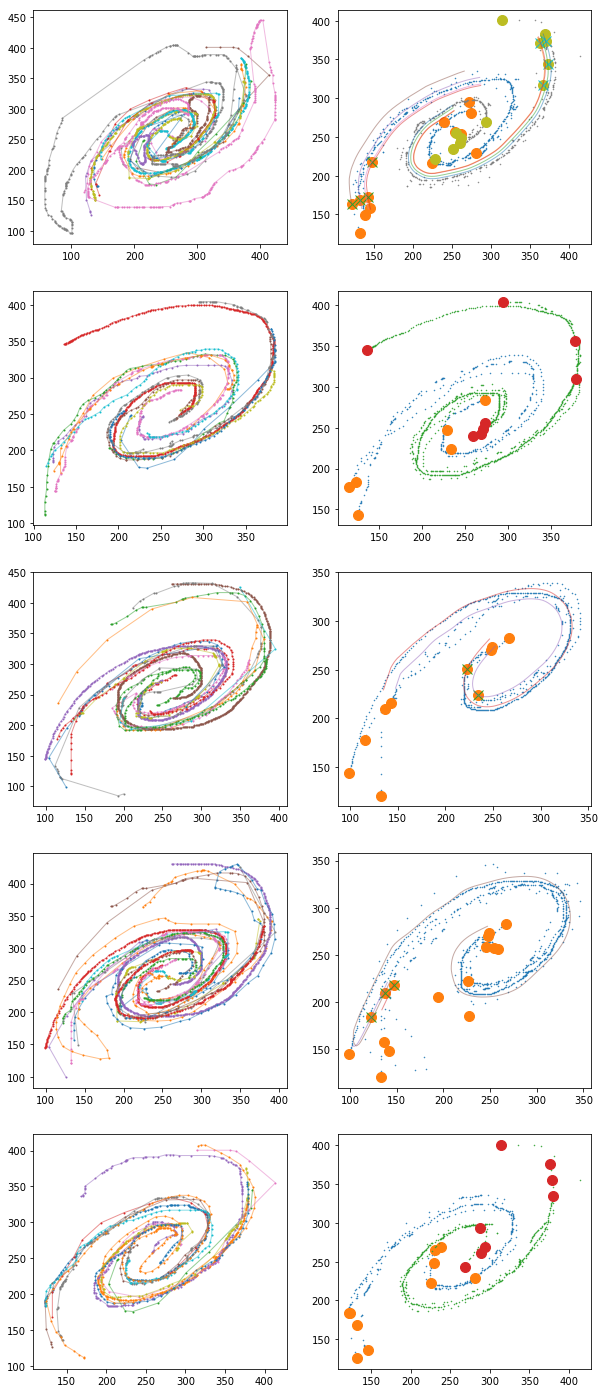

In [49]:
np.random.seed(0)
classificationGroups = [np.random.choice(np.arange(len(annotations)), size=10, replace=False) for i in range(5)]
fig, ax = plt.subplots(ncols=2, nrows=len(classificationGroups), figsize=(10, len(classificationGroups)*5))
splineGroups = []
for groupIndex, indices in enumerate(classificationGroups[:]):
    filteredAnnotations = [annotations[i] for i in indices]
    annotationsWithSpiral = [c[3]['value'][0]['value'] for c in filteredAnnotations if len(c[3]['value'][0]['value'])]
    spirals = [[a['points'] for a in c] for c in annotationsWithSpiral]
    spiralsWithLengthCut = [
        [[[p['x'], p['y']] for p in a] for a in c]
        for c in spirals if all([len(a) > 5 for a in c])
    ]
    drawnArms = np.array([np.array(arm) for classification in spiralsWithLengthCut for arm in classification])
    for index, arm in enumerate(drawnArms):
        ax[groupIndex][0].plot(arm[:, 0], arm[:, 1], linewidth=1, alpha=0.5, c='C{}'.format(index % 10))
        ax[groupIndex][0].plot(arm[:, 0], arm[:, 1], '.', markersize=2, c='C{}'.format(index % 10))
    splines = []
    armLabels = groupPolylines.clusterPolyLines(drawnArms)
    for armLabel in range(np.max(armLabels) + 1):
        pointCloud = np.concatenate(drawnArms[armLabels == armLabel])
        
        ax[groupIndex, 1].plot(pointCloud[:, 0], pointCloud[:, 1], '.', markerSize=1)
        startEndPoints = np.array(
            [i[0] for i in drawnArms[armLabels == armLabel]]
            + [i[-1] for i in drawnArms[armLabels == armLabel]]
        )
        ax[groupIndex, 1].plot(startEndPoints[:, 0], startEndPoints[:, 1], 'o', markerSize=10)
        
        cleanedCloud, outlierMask = groupPolylines.identifyOutliers(pointCloud)

        vectorField, variances = pcaSpiralExtract.getVectorField(cleanedCloud)
        varianceCutoffMask = variances[:, 0] / variances[:, 1] > 3.0
        cleanedVectorField = vectorField[varianceCutoffMask]

        startCluster = pcaSpiralExtract.getStartCluster(drawnArms[armLabels == armLabel], cleanedCloud)
        if startCluster.shape[0] == 0:
            print('>>>> No start cluster identified')
            continue
        ax[groupIndex, 1].plot(startCluster[:, 0], startCluster[:, 1], 'x', markersize=10)
        paths = pcaSpiralExtract.dropSticks(startCluster, cleanedVectorField)
        for path in paths:
            ax[groupIndex, 1].plot(path[:, 0], path[:, 1], linewidth=1, alpha=0.5)

        downstreamPoints = np.array([p[-1] for p in paths])
        upstreamPoints = np.array([p[0] for p in paths])

        downstreamClusterMask = pcaSpiralExtract.findDownstreamCluster(downstreamPoints)
        if not np.any(downstreamClusterMask):
            print('>>>> No downstream cluster identified')
            continue
        startPoint = (
            np.add.reduce(startCluster[downstreamClusterMask]) /
            startCluster[downstreamClusterMask].shape[0]
        )
        finalPath = pcaSpiralExtract.dropStick(startPoint, cleanedVectorField)
        res = pcaSpiralExtract.sortCloudAlongLine(cleanedCloud, finalPath)
        pointOrder = np.argsort(res[0])

        Sx, Sy = pcaSpiralExtract.fitParametrisedSpline(cleanedCloud[pointOrder]/512)
        splines.append([Sx, Sy])
#     splineGroups.append(splines)

In [47]:
list(filter(lambda i: i==2, [1,2,3] ))

[2]

In many cases spiral arms are identified (though the following steps of PCA and spline fitting may yet fail due to the low classification counts). However, there are cases where only one arm is properly identified.